### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
# import data handling class
from DT5550 import *

In [2]:
def four_gamma():
    if io.valid.sum() == 4:
        esum = 0
        nsum = 0
        tav  = 0
        tlist = []
        for idet in range(N_DETECTOR):
            E = io.Q[idet]
            if io.valid[idet]:
                if (E>1100) and (E<1350):
                    isel = idet
                    tsel = io.t[idet]
                else:
                    esum = esum + io.Q[idet]
                    tlist.append(io.t[idet])
                    nsum = nsum + 1
        
        if nsum==3:
            tlist = np.array(tlist)
            tav = tlist.mean()
            tstd = np.sqrt(tlist.var())
            E1.append(tstd)
            #print(tstd)
            if tstd<100 and tsel<tav and esum>800 and esum<1200:
                E0.append(esum)
                t0.append(tsel)
                t1.append(tav)

def two_gamma():
    if io.valid.sum() == 2:
        idet_sel = []
        for idet in range(N_DETECTOR):
            if io.valid[idet] and io.Q[idet]>400 and (idet!=4):#io.Q[idet]>490 and io.Q[idet]<530 and (idet!=4):
                idet_sel.append(idet)
        
        idet_sel = np.array(idet_sel)
        if len(idet_sel) == 2:
            E0.append(io.Q[idet_sel[0]])
            E1.append(io.Q[idet_sel[1]])
            t0.append(io.t[idet_sel[0]])
            t1.append(io.t[idet_sel[1]])
        

Filename to process

Open a datafile and read the data

In [3]:
#
# open the datfile
#
#io = DT5550(file='../../data/20211213_103444/data_20211213_103444_0.raw')
io = DT5550(indir='../../data/20211214_115511/')
#io = DT5550(file='../../DT5550_DAQ/daq/ReadoutClient/test0.raw')


t0 = []
t1 = []
E0 = []
E1 = []
nmax = 3
ifile = 0
for file in io.filenames:
    io.open_data(file)
    while io.read_event() == 0:
        if io.n_event%100000 == 0:
            print('Processed ',io.n_event,' events')
        # four gamma analysis    
        #####four_gamma()    
        # timing performance
        two_gamma()
    ifile = ifile +1
    if ifile>nmax:
        break
    
t0 = np.array(t0)
t1 = np.array(t1)
E0 = np.array(E0)
E1 = np.array(E1)
print('Processing done')

DT5550:: Data recorded with config:  ../../data/20211214_115511\config_20211214_115511.json
DT5550:: Open data file: ../../data/20211214_115511\data_20211214_115511_0.raw
Processed  100000  events
DT5550:: Open data file: ../../data/20211214_115511\data_20211214_115511_1.raw
Processed  200000  events
DT5550:: Open data file: ../../data/20211214_115511\data_20211214_115511_10.raw
Processed  300000  events
DT5550:: Open data file: ../../data/20211214_115511\data_20211214_115511_11.raw
Processed  400000  events
Processing done


A few basic plots: integrated charge and time

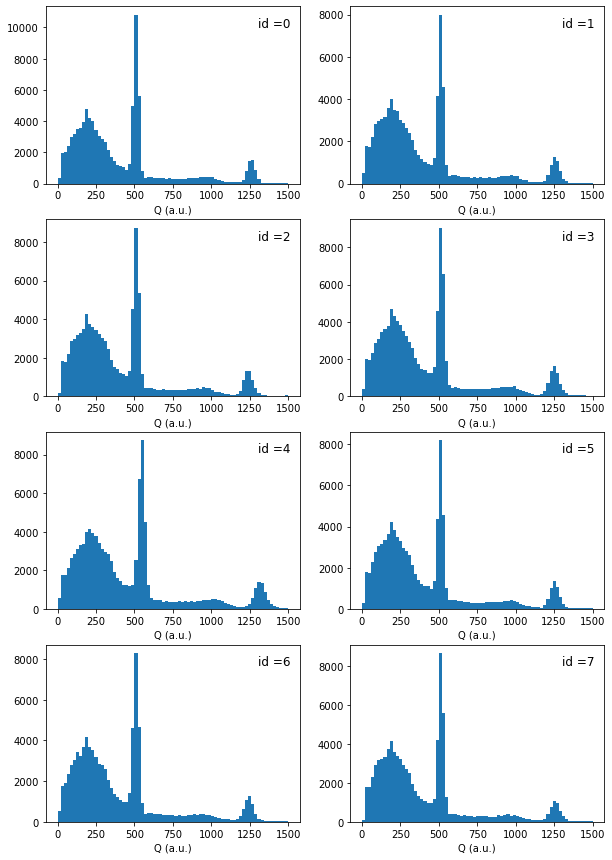

In [4]:
io.plot_all(type="charge",bins=75,logy=False, range=(0,1500))

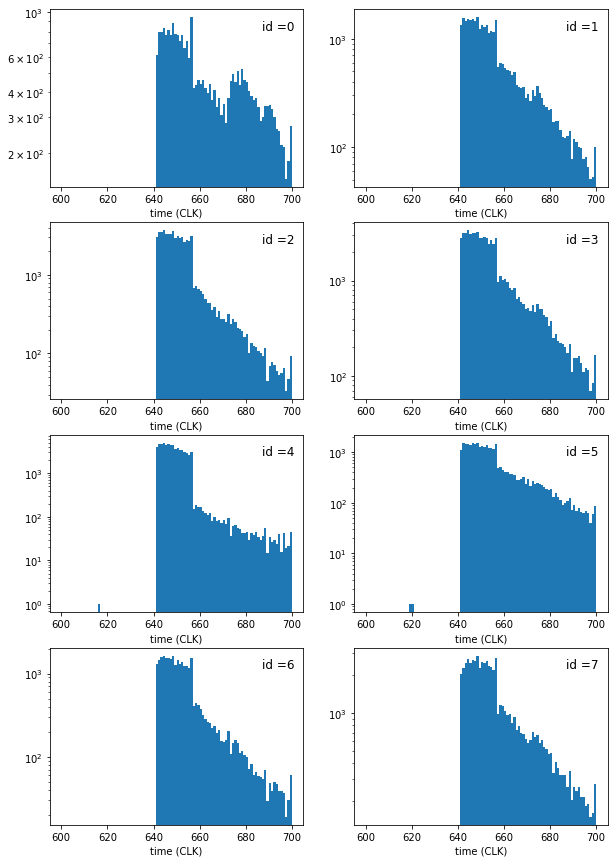

In [5]:
io.plot_all(type="time",range=(600,700),bins=100,logy=True)

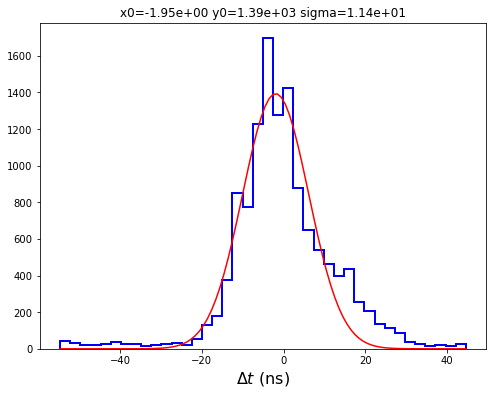

In [6]:
from scipy.optimize import curve_fit

plt.figure(figsize=(8,6))

dt = (t0-t1)*12.5/16
dt = dt[abs(dt+5)<50]

bins = 40
y, xe  = np.histogram(dt,bins=bins)
x = .5 * (xe[:-1] + xe[1:])

# Function to be fitted
def gauss(x, x0, y0, sigma):
    p = [x0, y0, sigma]
    return p[1]* np.exp(-((x-p[0])/p[2])**2)

# Initialization parameters
p0 = [1., 1., 1.]
# Fit the data with the function
fit, tmp = curve_fit(gauss, x, y, p0=p0)

# Plot the results
plt.title('x0=%.2e y0=%.2e sigma=%.2e' % (fit[0], fit[1], fit[2]))
# Data
plt.hist(dt,bins=bins,histtype='step',linewidth=2,color='blue')
#plt.plot(x, y, drawstyle='steps', color='blue',linewidth=2)
# Fitted function
x_fine = np.linspace(xe[0], xe[-1], 100)
plt.plot(x_fine, gauss(x_fine, fit[0], fit[1], fit[2]), 'r-')

plt.xlabel('$\Delta t$ (ns)',fontsize=16)

plt.savefig('Gaussian_fit.png')


In [7]:
E0[0]

1966.0

In [8]:
np.sqrt(dt[abs(dt-2.64)<10].var())/np.sqrt(2)

3.777518990022372

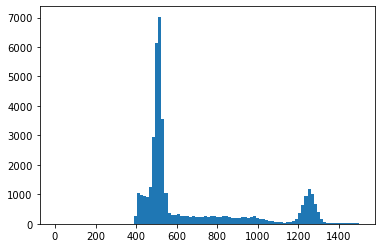

In [9]:
h= plt.hist(E0,bins=100,range=(0,1500))

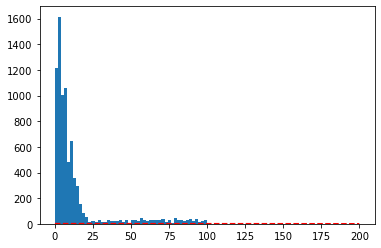

In [10]:
h=plt.hist((t1-t0)*12.5/16,bins=50,range=(0,100))
xx= np.arange(0,200,0.1)
yy= 1.5*np.exp(-xx/150)
plt.plot(xx,yy,'--',color='red')

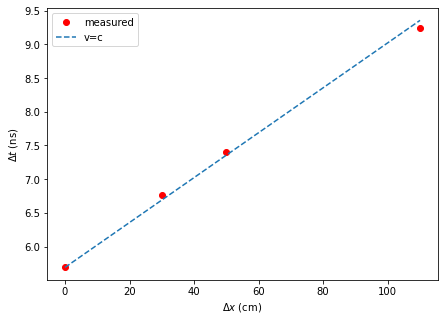

In [11]:
#
# speed of light measurement with Na22 source
#
y0=5.69
plt.figure(figsize=(7,5))
plt.plot([0,30,50,110],[5.69, 6.77, 7.40, 9.24],'o',color='red',label='measured')
plt.plot([0,110],[y0,y0+110/30],'--',label='v=c')
plt.legend()
plt.xlabel('$\Delta x$ (cm)')
plt.ylabel('$\Delta t$ (ns)')
plt.savefig('lightspeed.pdf')

In [12]:
io.valid

array([0., 0., 0., 1., 1., 0., 0., 0.])

In [13]:
1170/2450

0.4775510204081633